In [1]:
from matplotlib import pyplot as plt
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix 
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import model_from_json
from keras.utils import multi_gpu_model 
from keras.utils import to_categorical


Using TensorFlow backend.


Read the data
===========

In [2]:
x_original=pd.read_csv('_xlable4_withNa_AllColumns.txt')
y_original=pd.read_csv('_targelable4_withNa_AllColumns.txt')


# x_original=x_original[['Unnamed: 0','S000502', 'S000501', 'S000300', 'L190400', 'L190500', 'L190300', 'SEX',
#                        'L100700', 'L103000', 'L103300', 'L100800', 'L101700', 'AGE', 'L100500', 'L101300'
#                        ]]

x_original=x_original[['Unnamed: 0','S000501', 'S000502', 'S000300', 'L103000', 'L100700', 'L100800',
        'L101300', 'AGE', 'L103100', 'L101700', 'L103300',  'FIELD_42', 'L100500'
                       ]]

y_original=y_original[['Unnamed: 0','S000502']]


print(x_original.shape)
print(y_original.shape)


(159381, 14)
(159381, 2)


In [3]:
for index,col in enumerate(x_original.columns):
    print(col,x_original[col].dropna().shape[0])

Unnamed: 0 159381
S000501 159305
S000502 159305
S000300 159075
L103000 158939
L100700 152474
L100800 159236
L101300 159247
AGE 159381
L103100 158880
L101700 158951
L103300 135222
FIELD_42 159032
L100500 158954


Prepare the data
============

In [4]:
# df=x_original.copy()
# conditions = [
#     (df.S000501 < 120)  ,
#     (df.S000501 >= 120) & (df.S000501 < 130),
#     (df.S000501 >=130)]
# choices = [0,1,2]
# df['sbpG'] = np.select(conditions, choices, default=0)
# df.head()
# x_original=df.copy()

# conditions2 = [
#     (df.S000502 < 80)  ,
#     (df.S000502 >= 80) & (df.S000502 < 90),
#     (df.S000502 >=90)]
# choices2 = [0,1,2]
# df['dbpG'] = np.select(conditions2, choices2, default=0)
# df.head()
# x_original=df.copy()

# conditions3 = [
#     (df.AGE < 30)  ,
#     (df.AGE >= 30) & (df.AGE < 40),
#     (df.AGE >= 40) & (df.AGE < 50),
#     (df.AGE >= 50) & (df.AGE < 60),
#     (df.AGE >= 60)]
# choices3 = [0,1,2,3,4]
# df['AgeG'] = np.select(conditions3, choices3, default=0)
# df.head()
# x_original=df.copy()


# conditions4 = [
#     (df.L100800 < 100)  ,
#     (df.L100800 >= 100) & (df.L100800 < 126), 
#     (df.L100800 >= 126)]
# choices4 = [0,1,2]
# df['CLASS'] = np.select(conditions4, choices4, default=0)
# df.head()
# x_original=df.copy()

In [5]:
data= pd.merge(x_original,y_original, how='inner',left_on='Unnamed: 0', right_on='Unnamed: 0')
data=data.dropna(). reset_index()

# data=data[data.AGE_x >= 40]
# data=data[data.AGE_x < 50]

# data=data[data.CLASS_x==0]
# data=data[data.sbpG==0]
# data=data[data.dbpG==0]

# data=data[data.L100800_y <200]

print(data.shape)

(128822, 16)


In [6]:
print(data.shape)
print(data.columns)
data.head()

(128822, 16)
Index(['index', 'Unnamed: 0', 'S000501', 'S000502_x', 'S000300', 'L103000',
       'L100700', 'L100800', 'L101300', 'AGE', 'L103100', 'L101700', 'L103300',
       'FIELD_42', 'L100500', 'S000502_y'],
      dtype='object')


,index,Unnamed: 0,S000501,S000502_x,S000300,L103000,L100700,L100800,L101300,AGE,L103100,L101700,L103300,FIELD_42,L100500,S000502_y
0,0,0,121.0,67.0,20.1,53.0,3.0,77.0,8.0,44.0,68.0,13.0,3.1,4.0,0.8,76.0
1,1,1,117.0,76.0,19.7,53.0,3.0,89.0,9.0,45.0,71.0,14.0,3.3,4.0,0.8,82.0
2,2,2,135.0,82.0,20.2,41.0,3.8,78.0,10.0,46.0,72.0,15.0,3.4,3.0,0.8,78.0
3,3,3,118.0,71.0,24.8,58.0,3.7,95.0,12.0,51.0,64.0,10.0,2.8,0.0,0.8,65.0
4,4,4,111.0,65.0,25.5,50.0,3.4,90.0,12.0,52.0,58.0,12.0,2.9,1.0,0.8,65.0


In [7]:


x=data[['S000501', 'S000502_x', 'S000300', 'L103000', 'L100700', 'L100800',
       'L101300', 'AGE', 'L103100', 'L101700', 'L103300', 
        'FIELD_42', 'L100500']]

y=data[['S000502_y']]

Check the correlation of the selected feature with the independent variables
=====

In [8]:
temppd=pd.DataFrame(x.copy())
temppd['y']=y.S000502_y
temppd.head()
corval=abs(temppd.corr()).sort_values(by='y', ascending=False)

In [9]:
corval.y

y            1.000000
S000502_x    0.587031
S000501      0.576590
S000300      0.371540
L100700      0.310342
L103300      0.268552
L103000      0.258079
L101700      0.245681
L100500      0.245513
L100800      0.241421
L101300      0.218320
L103100      0.199149
AGE          0.167668
FIELD_42     0.012092
Name: y, dtype: float64

In [10]:
#histogram plot of the features
# import matplotlib.pyplot as plt
# x[x.dtypes[(x.dtypes=="float64")|(x.dtypes=="int64")]
#                         .index.values].hist(figsize=[11,11])

Apply PCA
===========

In [11]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=8)
# pca.fit(x)

# print(pca.explained_variance_ratio_)   
# print(np.sum(pca.explained_variance_ratio_))

# x=pca.fit_transform(x) 
# print(x.shape)


feature scaling
=======

In [12]:
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()  #StandardScaler()
# x = min_max_scaler.fit_transform(x)

clustring test
==========

In [13]:
# from sklearn.cluster import KMeans
# from scipy.spatial.distance import cdist

# K = range(1,10)
# distortions = []

# for k in K:
#     kmeanModel = KMeans(n_clusters=k).fit(x)
#     kmeanModel.fit(x)
#     distortions.append(sum(np.min(cdist(x, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / x.shape[0])

# # Plot the elbow
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()


In [14]:
# kmeanModel = KMeans(n_clusters=k).fit(x)
# x['lbl']=kmeanModel.labels_ 

In [24]:
print(ytrain.shape)
print(ytest.shape)

(103057, 1)
(25765, 1)


Random Forest Regressor
=============

In [16]:
ylable=y[['S000502_y']]  
xtrain,xtest,ytrain,ytest=train_test_split(x, ylable, random_state=42, test_size=0.2)

In [17]:
regr = RandomForestRegressor(max_depth=7, random_state=0,verbose =0,n_estimators=500)
regr.fit(xtrain, ytrain) 
print(regr.feature_importances_)
ypred=regr.predict(xtest)


[2.79748405e-01 6.37019829e-01 2.08793359e-02 3.28424514e-03
 1.05849191e-02 1.37625263e-03 1.80925260e-03 1.11796814e-02
 1.19764813e-03 2.89443559e-02 2.12150867e-03 2.72412172e-04
 1.58215474e-03]


mean_squared_error 49.74243367029806
root mean_squared_error 7.052831606546271
mean_absolute_error 5.684093030597248
r2_score 0.40569740843293056


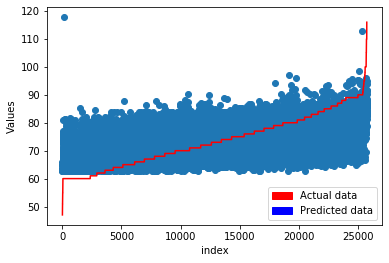

,t + 1,pred (t +1)
11109,110.0,91.685774
24297,110.0,87.802218
21262,110.0,87.080948
14437,110.0,87.674716
13701,110.0,82.488706
15162,110.0,94.806131
10113,112.0,84.191780
23121,113.0,78.903628
6142,115.0,91.213051
4693,116.0,85.275010


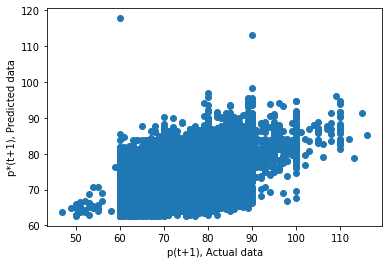

In [18]:

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(30)

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.tail(10)

In [26]:
ypredPD["diff"] = abs(ypredPD["t + 1"] - ypredPD["pred (t +1)"])
ypredPD["diff"] = abs(ypredPD["t + 1"] - ypredPD["pred (t +1)"])
print("|Actual - predicted < 5 mmHg|", "{:.1f}%".format(100 * ypredPD[ypredPD["diff"] < 5].shape[0] / ypredPD.shape[0]))
print("|Actual - predicted < 10 mmHg|", "{:.1f}%".format(100 * ypredPD[ypredPD["diff"] < 10].shape[0] / ypredPD.shape[0]))
print("|Actual - predicted < 15 mmHg|", "{:.1f}%".format(100 * ypredPD[ypredPD["diff"] < 15].shape[0] / ypredPD.shape[0]))
print("|Actual - predicted < 20 mmHg|", "{:.1f}%".format(100 * ypredPD[ypredPD["diff"] < 20].shape[0] / ypredPD.shape[0]))
print("|Actual - predicted < 25 mmHg|", "{:.1f}%".format(100 * ypredPD[ypredPD["diff"] < 25].shape[0] / ypredPD.shape[0]))
print("|Actual - predicted < 30 mmHg|", "{:.1f}%".format(100 * ypredPD[ypredPD["diff"] < 30].shape[0] / ypredPD.shape[0]))


|Actual - predicted < 5 mmHg| 51.0%
|Actual - predicted < 10 mmHg| 85.1%
|Actual - predicted < 15 mmHg| 96.9%
|Actual - predicted < 20 mmHg| 99.5%
|Actual - predicted < 25 mmHg| 99.9%
|Actual - predicted < 30 mmHg| 100.0%


xg boost
==========

In [27]:
import xgboost as xgb
# from sklearn.metrics import mean_squared_error
# import pandas as pd
# import numpy as np

In [28]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror')
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, 
#                           learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(xtrain, ytrain) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [29]:

ypred = xg_reg.predict(xtest)

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

# ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
# ypredPD['t + 1']=ytest.values
# ypredPD['pred (t +1)']=ypred
# ypredPD.head(10)

mean_squared_error 49.24942753265354
root mean_squared_error 7.017793637080927
mean_absolute_error 5.646090830753503
r2_score 0.41158764748320775


|Actual - predicted < 5 mmHg| 51.0%
|Actual - predicted < 10 mmHg| 85.1%
|Actual - predicted < 15 mmHg| 96.9%
|Actual - predicted < 20 mmHg| 99.5%
|Actual - predicted < 25 mmHg| 99.9%
|Actual - predicted < 30 mmHg| 100.0%


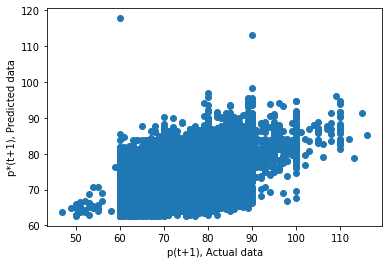

In [30]:
ypredPD["diff"] = abs(ypredPD["t + 1"] - ypredPD["pred (t +1)"])
print("|Actual - predicted < 5 mmHg|", "{:.1f}%".format(100 * ypredPD[ypredPD["diff"] < 5].shape[0] / ypredPD.shape[0]))
print("|Actual - predicted < 10 mmHg|", "{:.1f}%".format(100 * ypredPD[ypredPD["diff"] < 10].shape[0] / ypredPD.shape[0]))
print("|Actual - predicted < 15 mmHg|", "{:.1f}%".format(100 * ypredPD[ypredPD["diff"] < 15].shape[0] / ypredPD.shape[0]))
print("|Actual - predicted < 20 mmHg|", "{:.1f}%".format(100 * ypredPD[ypredPD["diff"] < 20].shape[0] / ypredPD.shape[0]))
print("|Actual - predicted < 25 mmHg|", "{:.1f}%".format(100 * ypredPD[ypredPD["diff"] < 25].shape[0] / ypredPD.shape[0]))
print("|Actual - predicted < 30 mmHg|", "{:.1f}%".format(100 * ypredPD[ypredPD["diff"] < 30].shape[0] / ypredPD.shape[0]))

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])


ANN
==========

In [ ]:
model= Sequential()
model.add(Dense(input_dim=32,units=128,activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=128, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=64, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=32, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=16, activation='relu', kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=8, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=1, kernel_initializer='uniform'))
model.compile(loss='mean_squared_error', optimizer='Nadam', metrics=['mean_squared_error' ])

In [ ]:
h=model.fit(xtrain, ytrain, validation_split=.2,epochs=100, batch_size=50)

In [ ]:
ypred=model.predict(xtest)

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)

In [ ]:
history=h
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['mean_squared_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
ypredPD['diff']=abs(ypredPD['t + 1']- ypredPD['pred (t +1)'])
print(np.mean(ypredPD['diff']))
print(np.std(ypredPD['diff']))
print(100*ypredPD[ypredPD['diff']<=5].shape[0]/ypredPD.shape[0])

In [ ]:

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.head(10)

SVR
======

In [ ]:
from sklearn.svm import SVR
# svr_rbf = SVR(kernel='rbf', C=10, gamma=0.02, epsilon=.001)
svr_rbf = SVR(kernel='rbf')

In [ ]:
svr_rbf.fit(xtrain, ytrain) 

In [ ]:
ypred=svr_rbf.predict(xtest)

In [ ]:
import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)